In [10]:
### General
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, vstack, join
from astroquery.gaia import Gaia

### Tools
import sys
sys.path.append('../')
from wdphoto import LaPlataInterpolator, WarwickDAInterpolator, PhotometryEngine, deredden

In [11]:
catalog = Table.read('raddi.csv')


In [12]:
stardats = []
# Astroquery row limits mean that if the length of the table is more than 2000, split the query into multiple calls.
iters = (len(catalog)+2000) // 2000

for i in range(iters):
    ADQL_CODE = """SELECT dist.source_id, dist.r_med_geo
                    FROM gaiadr3.gaia_source as gaia
                    JOIN external.gaiaedr3_distance as dist
                    ON gaia.source_id = dist.source_id      
                    WHERE gaia.source_id in {}""".format(tuple(catalog['SOURCE_ID'][2000*i:2000*i+2000]))
    stardats.append(Gaia.launch_job(ADQL_CODE,dump_to_file=False).get_results())
gaia_data = vstack(stardats)
catalog = join(catalog, gaia_data, keys_left='SOURCE_ID', keys_right='source_id')
    

In [13]:
bands = ['Gaia_BP', 'Gaia_RP']

warwick_interpolator = WarwickDAInterpolator(bands = bands, precache=True)
co_hrich = LaPlataInterpolator('CO', 'Hrich', '0_02', bands, logg_lims = (8.95, 9.15))
co_hdef = LaPlataInterpolator('CO', 'Hdef', '0_02', bands, logg_lims = (8.95, 9.15))
one_hrich = LaPlataInterpolator('ONe', 'Hrich', '0_02', bands, logg_lims = (8.95, 9.15))
one_hdef = LaPlataInterpolator('ONe', 'Hdef', '0_02', bands, logg_lims = (8.95, 9.15))

WarwickEngine = PhotometryEngine(warwick_interpolator)
CO_HrichEngine = PhotometryEngine(co_hrich)
CO_HdefEngine = PhotometryEngine(co_hdef)
ONe_HrichEngine = PhotometryEngine(one_hrich)
ONe_HdefEngine = PhotometryEngine(one_hdef)

In [14]:
obs_mag = np.array(catalog[['phot_bp_mean_mag', 'phot_rp_mean_mag']])
e_obs_mag = np.array(catalog[['e_bpmag', 'e_rpmag']])
distances = np.array(catalog['r_med_geo'])

In [15]:
obs_mag[0]

(18.00009346, 17.99886894)

In [16]:
WarwickEngine(obs_mag[0], e_obs_mag[0], distances[0])

(0.01604445528448102,
 5.727172791570431e-07,
 11760.129865500963,
 0.3331414358543896,
 2.9682016328909657e-12)

In [17]:
outs = np.nan*np.zeros((5, len(obs_mag), 5))

for i in tqdm(range(len(obs_mag))):
    outs[0,i] = WarwickEngine(obs_mag[i], e_obs_mag[i], distances[i])
    outs[1,i] = CO_HrichEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])
    outs[2,i] = CO_HdefEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])
    outs[3,i] = ONe_HrichEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])
    outs[4,i] = ONe_HdefEngine(obs_mag[i], e_obs_mag[i], distances[i], p0 = [10000, 9, 0.003])

100%|██████████| 3128/3128 [08:21<00:00,  6.24it/s]


In [36]:
['Warwick', 'CO_Hrich', 'CO_Hdef', 'ONe_Hrich', 'ONe_Hdef', 'Raddi']

catalog.rename_column('Radius', 'Raddi_radius')

catalog['Warwick_radius'] = outs[0,:,0]
catalog['Warwick_e_radius'] = outs[0,:,1]
catalog['Warwick_teff'] = outs[0,:,2]
catalog['Warwick_e_teff'] = outs[0,:,3]
catalog['Warwick_chi2'] = outs[0,:,4]
catalog['Warwick_roe'] = catalog['Warwick_radius'] / catalog['Warwick_e_radius']

catalog['CO_Hrich_radius'] = outs[1,:,0]
catalog['CO_Hrich_e_radius'] = outs[1,:,1]
catalog['CO_Hrich_teff'] = outs[1,:,2]
catalog['CO_Hrich_e_teff'] = outs[1,:,3]
catalog['CO_Hrich_chi2'] = outs[1,:,4]
catalog['CO_Hrich_roe'] = catalog['CO_Hrich_radius']/catalog['CO_Hrich_e_radius']

catalog['CO_Hdef_radius'] = outs[2,:,0]
catalog['CO_Hdef_e_radius'] = outs[2,:,1]
catalog['CO_Hdef_teff'] = outs[2,:,2]
catalog['CO_Hdef_e_teff'] = outs[2,:,3]
catalog['CO_Hdef_chi2'] = outs[2,:,4]
catalog['CO_Hdef_roe'] = catalog['CO_Hdef_radius']/catalog['CO_Hdef_e_radius']

catalog['ONe_Hrich_radius'] = outs[3,:,0]
catalog['ONe_Hrich_e_radius'] = outs[3,:,1]
catalog['ONe_Hrich_teff'] = outs[3,:,2]
catalog['ONe_Hrich_e_teff'] = outs[3,:,3]
catalog['ONe_Hrich_chi2'] = outs[3,:,4]
catalog['ONe_Hrich_roe'] = catalog['ONe_Hrich_radius']/catalog['ONe_Hrich_e_radius']

catalog['ONe_Hdef_radius'] = outs[4,:,0]
catalog['ONe_Hdef_e_radius'] = outs[4,:,1]
catalog['ONe_Hdef_teff'] = outs[4,:,2]
catalog['ONe_Hdef_e_teff'] = outs[4,:,3]
catalog['ONe_Hdef_chi2'] = outs[4,:,4]
catalog['ONe_Hdef_roe'] = catalog['ONe_Hdef_radius']/catalog['ONe_Hdef_e_radius']

In [51]:
Warwick_failed = np.any([catalog['Warwick_chi2'] > 5, catalog['Warwick_roe'] < 5], axis=0)
CO_Hrich_failed = np.any([catalog['CO_Hrich_chi2'] > 5, catalog['CO_Hrich_roe'] < 5], axis=0)
CO_Hdef_failed = np.any([catalog['CO_Hdef_chi2'] > 5, catalog['CO_Hdef_roe'] < 5], axis=0)
ONe_Hrich_failed = np.any([catalog['ONe_Hrich_chi2'] > 5, catalog['ONe_Hrich_roe'] < 5], axis=0)
ONe_Hdef_failed = np.any([catalog['ONe_Hdef_chi2'] > 5, catalog['ONe_Hdef_roe'] < 5], axis=0)

In [52]:
print(f'Warwick_failed={len(catalog[Warwick_failed])/len(catalog)*100:2.2f}%')
print(f'CO_Hrich_failed={len(catalog[CO_Hrich_failed])/len(catalog)*100:2.2f}%')
print(f'CO_Hdef_failed={len(catalog[CO_Hdef_failed])/len(catalog)*100:2.2f}%')
print(f'ONe_Hrich_failed={len(catalog[ONe_Hrich_failed])/len(catalog)*100:2.2f}%')
print(f'ONe_Hdef_failed={len(catalog[ONe_Hdef_failed])/len(catalog)*100:2.2f}%')

mask = np.all([~Warwick_failed, ~CO_Hrich_failed, ~CO_Hdef_failed,
               ~ONe_Hrich_failed, ~ONe_Hdef_failed], axis=0)
print(f'\nTotal failed={(1-len(catalog[mask])/len(catalog))*100:2.2f}%')

Warwick_failed=0.67%
CO_Hrich_failed=6.62%
CO_Hdef_failed=1.12%
ONe_Hrich_failed=2.53%
ONe_Hdef_failed=1.37%

Total failed=9.18%


Text(0, 0.5, 'CO_Hrich Radius')

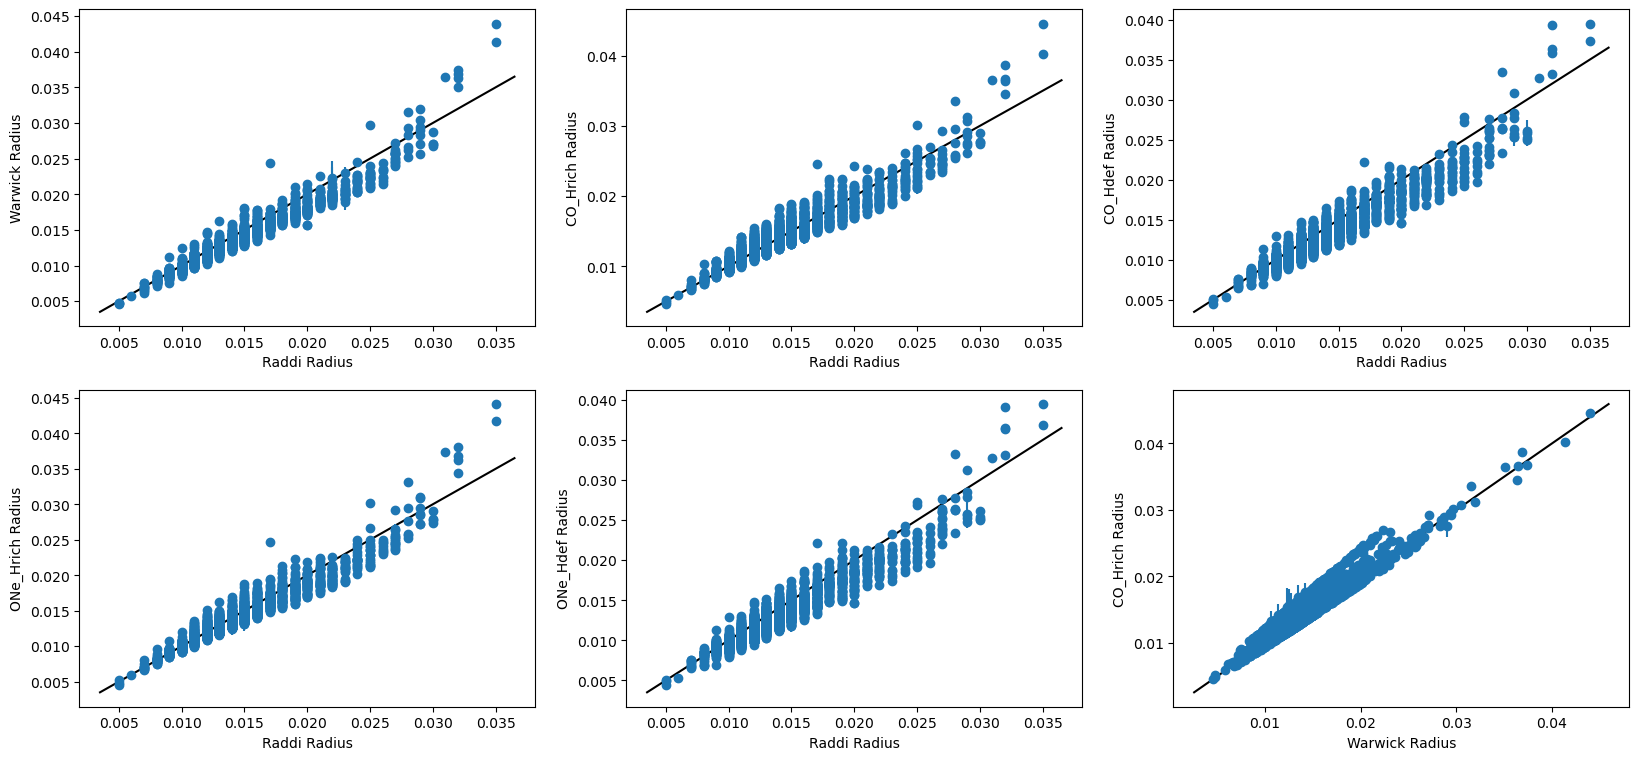

In [55]:
plt.figure(figsize=(20,14))

plt.subplot(331)
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['Warwick_radius'], yerr=catalog[mask]['Warwick_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('Warwick Radius')

plt.subplot(332)
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['CO_Hrich_radius'], yerr=catalog[mask]['CO_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('CO_Hrich Radius')

plt.subplot(333)
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['CO_Hdef_radius'], yerr=catalog[mask]['CO_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('CO_Hdef Radius')

plt.subplot(334)
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['ONe_Hrich_radius'], yerr=catalog[mask]['ONe_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('ONe_Hrich Radius')

plt.subplot(335)
plt.errorbar(catalog[mask]['Raddi_radius'], catalog[mask]['ONe_Hdef_radius'], yerr=catalog[mask]['ONe_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('ONe_Hdef Radius')

plt.subplot(336)
plt.errorbar(catalog[mask]['Warwick_radius'], catalog[mask]['CO_Hrich_radius'], yerr=catalog[mask]['CO_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Warwick Radius')
plt.ylabel('CO_Hrich Radius')

Text(0, 0.5, 'Raddi Radius')

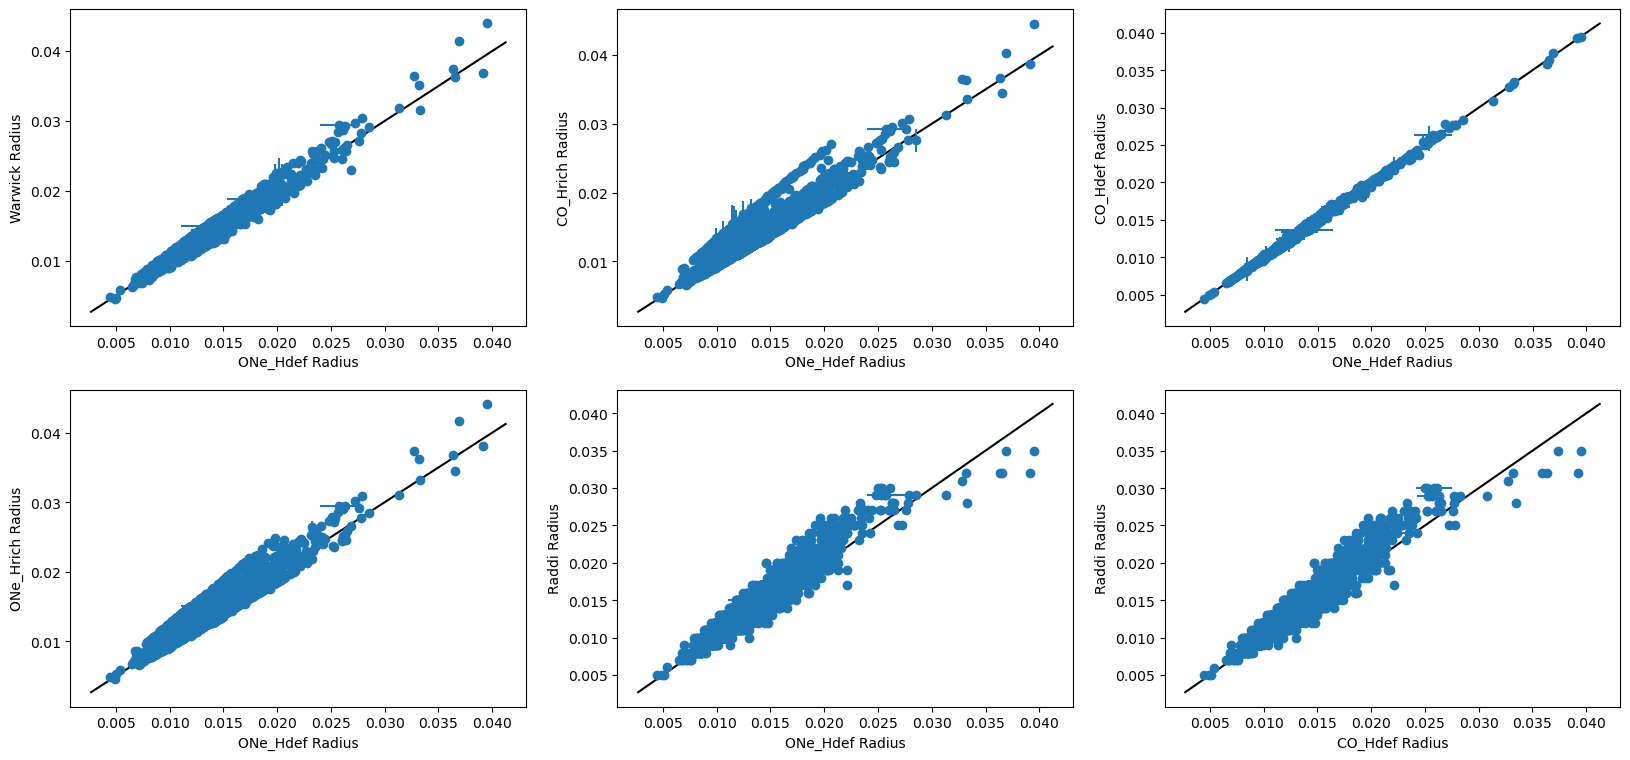

In [57]:
plt.figure(figsize=(20,14))

plt.subplot(331)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['Warwick_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], yerr=catalog[mask]['Warwick_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('Warwick Radius')

plt.subplot(332)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['CO_Hrich_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], yerr=catalog[mask]['CO_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('CO_Hrich Radius')

plt.subplot(333)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['CO_Hdef_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], yerr=catalog[mask]['CO_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('CO_Hdef Radius')

plt.subplot(334)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['ONe_Hrich_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], yerr=catalog[mask]['ONe_Hrich_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('ONe_Hrich Radius')

plt.subplot(335)
plt.errorbar(catalog[mask]['ONe_Hdef_radius'], catalog[mask]['Raddi_radius'], 
             xerr = catalog[mask]['ONe_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('ONe_Hdef Radius')
plt.ylabel('Raddi Radius')

plt.subplot(336)
plt.errorbar(catalog[mask]['CO_Hdef_radius'], catalog[mask]['Raddi_radius'], 
             xerr = catalog[mask]['CO_Hdef_e_radius'], fmt='o')
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('CO_Hdef Radius')
plt.ylabel('Raddi Radius')



In [58]:
model = ['Warwick', 'CO_Hrich', 'CO_Hdef', 'ONe_Hrich', 'ONe_Hdef', 'Raddi']
mae_matrix = np.zeros((len(model), len(model)))
mpe_matrix = np.zeros((len(model), len(model)))
bias_matrix = np.zeros((len(model), len(model)))

for i in range(len(model)):
    for j in range(len(model)):
        if (i != j):
            print(f'{model[i]} and {model[j]}')
            mae = np.sum(np.abs(catalog[mask][model[i]+'_radius'] - catalog[mask][model[j]+'_radius'])) / len(catalog[mask])
            mpe = np.average(np.abs(catalog[mask][model[i]+'_radius'] - catalog[mask][model[j]+'_radius'] / catalog[mask][model[i]+'_radius']))*100
            bias = np.average(catalog[mask][model[i]+'_radius'] - catalog[mask][model[j]+'_radius'])

            mae_matrix[i,j] = mae
            mpe_matrix[i,j] = mpe
            bias_matrix[i,j] = bias

            print(f'    mean absolute error: {mae:f}')
            print(f'    bias: {bias:f}\n')
            



Warwick and CO_Hrich
    mean absolute error: 0.000899
    bias: -0.000491

Warwick and CO_Hdef
    mean absolute error: 0.000665
    bias: 0.000203

Warwick and ONe_Hrich
    mean absolute error: 0.000668
    bias: -0.000286

Warwick and ONe_Hdef
    mean absolute error: 0.000645
    bias: 0.000194

Warwick and Raddi
    mean absolute error: 0.000787
    bias: -0.000616

CO_Hrich and Warwick
    mean absolute error: 0.000899
    bias: 0.000491

CO_Hrich and CO_Hdef
    mean absolute error: 0.001287
    bias: 0.000695

CO_Hrich and ONe_Hrich
    mean absolute error: 0.000256
    bias: 0.000206

CO_Hrich and ONe_Hdef
    mean absolute error: 0.001273
    bias: 0.000686

CO_Hrich and Raddi
    mean absolute error: 0.000891
    bias: -0.000125

CO_Hdef and Warwick
    mean absolute error: 0.000665
    bias: -0.000203

CO_Hdef and CO_Hrich
    mean absolute error: 0.001287
    bias: -0.000695

CO_Hdef and ONe_Hrich
    mean absolute error: 0.001110
    bias: -0.000489

CO_Hdef and ONe_Hdef

(-0.5, 5.5, 5.5, -0.5)

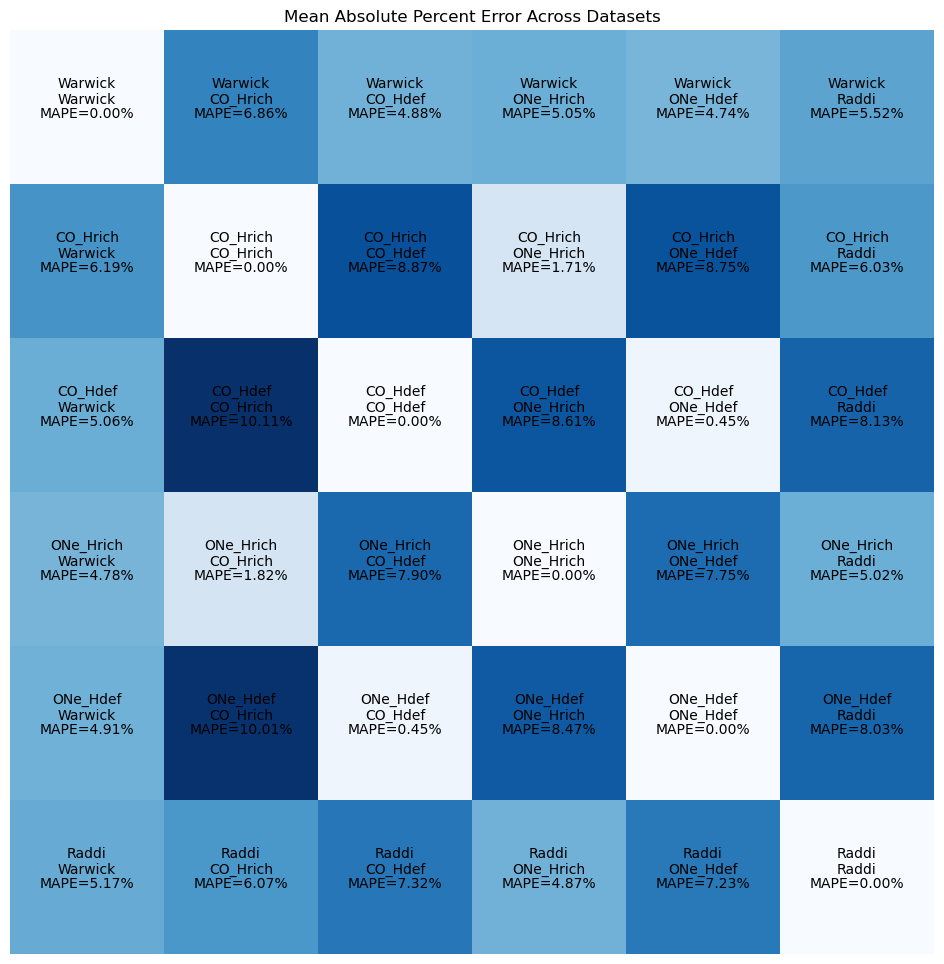

In [60]:
plt.figure(figsize=(12, 12))
plt.imshow(mpe_matrix, cmap='Blues')
for i in range(len(model)):
    for j in range(len(model)):
        chstr = model[i] + '\n' + model[j]
        plt.text(j,i,chstr, ha='center', va='bottom', color='black')
        plt.text(j, i, f'MAPE={mpe_matrix[i,j]:2.2f}%', ha='center', va='top', color='black')
        #plt.text(j, i, f'MPE={mpe_matrix[i,j]:0.5f}', ha='center', va='top', color='black')
plt.title('Mean Absolute Percent Error Across Datasets')
plt.axis('off')
